# MERFISH CCF mapped coordinates

Registration to the Allen CCFv3 was performed at 10 micron in-plane resolution. For each section, an anatomical label reference was created using class/subclass level cell type assignments which are then used to match to corresponding CCF parcellations. The midline was manually determined for each section to rotate the section upright and center in in the middle (**section coordinates**). This set of rectified images were stacked in sequential order to create an inital configuration for registration.

The ANTS registration framework was use to establish a 2.5D deformable spatial mapping between the MERFISH data and **CCF coordinates** via three major steps: (1) A 3D global affine (12 dof) mapping was performed to align the CCF into the MERFISH space (**resampled CCF**); (2) 2D affine (6 dof) registration of each MERFISH section to match the target resampled CCF section and finally, (3) a 2D multi-scale, symmetric diffeomorphic registration of each section (**reconstructed coordinates**) to finer level match to the target CCF section. Global and section-wise mappings from each of these registration steps were preserved and concatenated (with appropriate inversions) to allow point-to-point mapping between the original MERFISH coordinate space and the CCF space. See [Yao et al](https://doi.org/10.1101/2023.03.06.531121) for further details.

The purpose of this notebook is to provide an overview of how the mapped coordinate information is represented through example use cases.

You need to be connected to the internet to run this notebook and that you have already downloaded the data via the getting started notebook.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pathlib

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

We will interact with the data using the **AbcProjectCache**. This cache object tracks which data has been downloaded and serves the path to the requsted data on disk. For metadata, the cache can also directly serve a up a Pandas Dataframe. See the ``getting_started`` notebook for more details on using the cache including installing it if it has not already been.

**Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
version = '20231215'
download_base = pathlib.Path('../../abc_download_root')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
abc_cache.load_manifest(f'releases/{version}/manifest.json')
abc_cache.current_manifest

'releases/20231215/manifest.json'

### Read in section, reconstructed and CCF coordinates for all cells

Read in the expanded cell metadata table we created in part 1 of the MERFISH tutorial. To keep track of the three type of coordinates we will rename the **section coordinates** (x,y,z) in the dataframe to (x_section, y_section, z_section)

In [3]:
cell = abc_cache.get_metadata_dataframe(directory='MERFISH-C57BL6J-638850', file_name='cell_metadata_with_cluster_annotation')
cell.rename(columns={'x': 'x_section',
                     'y': 'y_section',
                     'z': 'z_section'},
            inplace=True)
cell.set_index('cell_label', inplace=True)
cell.head(5)

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x_section,y_section,z_section,neurotransmitter,class,subclass,supertype,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color
cell_label,,,,,,,,,,,,,,,,,,,,
1019171907102340387-1,C57BL6J-638850.37,1408,0.596276,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.226245,4.148963,6.6,NaN,04 DG-IMN Glut,038 DG-PIR Ex IMN,0141 DG-PIR Ex IMN_2,0515 DG-PIR Ex IMN_2,#666666,#16f2f2,#3D53CC,#CC7A3D,#73FFBF
1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,4.2,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,4.0,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,2.4,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63
1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,4.4,Glut,23 P Glut,235 PG-TRN-LRN Fat2 Glut,0953 PG-TRN-LRN Fat2 Glut_1,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63


Next we read in the **reconstructed coordinates** and mapped parcellation from the metadata directory and join it to the cell dataframe

In [4]:
reconstructed_coords = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='reconstructed_coordinates',
    dtype={"cell_label": str}
)
reconstructed_coords.rename(columns={'x': 'x_reconstructed',
                                     'y': 'y_reconstructed',
                                     'z': 'z_reconstructed'},
                            inplace=True)
reconstructed_coords.set_index('cell_label', inplace=True)
reconstructed_coords.head(5)

reconstructed_coordinates.csv: 100%|██████████████████████████████████████████████████████████████████████████████| 256M/256M [00:06<00:00, 38.0MMB/s]


,x_reconstructed,y_reconstructed,z_reconstructed,parcellation_index
cell_label,,,,
1019171911101460569,7.143894,7.890964,0.8,945
1019171911101550321,4.188673,7.962972,0.8,945
1019171911100841066,6.859447,5.908534,0.8,893
1019171911101400425,3.952014,7.564086,0.8,842
1019171911101380264,2.803546,7.221688,0.8,0


In [5]:
cell_joined = cell.join(reconstructed_coords, how='inner')
cell_joined.head(5)

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x_section,y_section,z_section,...,cluster,neurotransmitter_color,class_color,subclass_color,supertype_color,cluster_color,x_reconstructed,y_reconstructed,z_reconstructed,parcellation_index
cell_label,,,,,,,,,,,,,,,,,,,,,
1019171907102340387-1,C57BL6J-638850.37,1408,0.596276,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.226245,4.148963,6.6,...,0515 DG-PIR Ex IMN_2,#666666,#16f2f2,#3D53CC,#CC7A3D,#73FFBF,7.255606,4.007680,6.6,1160
1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,4.2,...,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63,5.036436,7.264429,4.2,564
1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,4.0,...,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63,5.784270,8.007646,4.0,761
1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,2.4,...,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63,3.161528,5.719814,2.4,718
1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,4.4,...,4199 PG-TRN-LRN Fat2 Glut_1,#2B93DF,#6b5ca5,#9B7ACC,#990041,#663D63,5.618763,7.847877,4.4,761


We repeat the process for the cell **CCF coordinates**

In [6]:
ccf_coords = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='ccf_coordinates',
    dtype={"cell_label": str}
)
ccf_coords.rename(columns={'x': 'x_ccf',
                           'y': 'y_ccf',
                           'z': 'z_ccf'},
                  inplace=True)
ccf_coords.drop(['parcellation_index'], axis=1, inplace=True)
ccf_coords.set_index('cell_label', inplace=True)
ccf_coords.head(5)

ccf_coordinates.csv: 100%|████████████████████████████████████████████████████████████████████████████████████████| 296M/296M [00:08<00:00, 35.9MMB/s]


,x_ccf,y_ccf,z_ccf
cell_label,,,
1019171911101460569,12.282330,6.987808,7.385773
1019171911101550321,12.192214,7.002155,4.366855
1019171911100841066,12.500341,4.750392,7.074634
1019171911101400425,12.231647,6.544816,4.128568
1019171911101380264,12.238502,6.135836,2.948194


In [7]:
cell_joined = cell_joined.join(ccf_coords, how='inner')
cell_joined.head(5)

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x_section,y_section,z_section,...,subclass_color,supertype_color,cluster_color,x_reconstructed,y_reconstructed,z_reconstructed,parcellation_index,x_ccf,y_ccf,z_ccf
cell_label,,,,,,,,,,,,,,,,,,,,,
1019171907102340387-1,C57BL6J-638850.37,1408,0.596276,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.226245,4.148963,6.6,...,#3D53CC,#CC7A3D,#73FFBF,7.255606,4.007680,6.6,1160,7.495417,2.445872,7.455066
1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,4.2,...,#9B7ACC,#990041,#663D63,5.036436,7.264429,4.2,564,9.227966,6.133693,5.225024
1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,4.0,...,#9B7ACC,#990041,#663D63,5.784270,8.007646,4.0,761,9.344912,6.989939,6.002664
1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,2.4,...,#9B7ACC,#990041,#663D63,3.161528,5.719814,2.4,718,10.977068,4.398568,3.305223
1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,4.4,...,#9B7ACC,#990041,#663D63,5.618763,7.847877,4.4,761,8.997138,6.798329,5.827197


### Visualize cells in section, reconstruced and CCF coordinates

We define a helper function to visualize cells in a section colorized by either cluster or annotation term and optionally with a boundary overlay

In [8]:
def plot_section(xx=None, yy=None, cc=None, val=None, pcmap=None, 
                 overlay=None, extent=None, bcmap=plt.cm.Greys_r, alpha=1.0,
                 fig_width = 6, fig_height = 6):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    if xx is not None and yy is not None and pcmap is not None:
        plt.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=pcmap)
    elif xx is not None and yy is not None and cc is not None:
        plt.scatter(xx, yy, s=0.5, color=cc, marker='.', zorder=1)   
        
    if overlay is not None and extent is not None and bcmap is not None:
        plt.imshow(overlay, cmap=bcmap, extent=extent, alpha=alpha, zorder=2)
        
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig, ax

For example section "C57BL6J-638850.40", we plot cells by **section, reconstructed and ccf coordinates** colorized by neurotransmitter type assignment. Note that cells from a single brain section remains together at the same z (posterior-to-anterior) value in section and reconstructed coordinates. Since the brain sections are at an angle compared to the CCF, the cells are spread across multiple x (anterior-to-posterior) CCF coordinates.

In [9]:
brain_section = 'C57BL6J-638850.40'
pred = (cell_joined['brain_section_label'] == brain_section)
section = cell_joined[pred]
print(len(section))

104572


In [10]:
print("z_section values:", np.unique(section['z_section']))
print("z_reconstructed values:", np.unique(section['z_reconstructed']))
print("x_ccf values:", np.unique(section['x_ccf']))

z_section values: [7.2]
z_reconstructed values: [7.2]
x_ccf values: [6.32598314 6.32656693 6.3266852  ... 7.16574148 7.16579943 7.16598123]


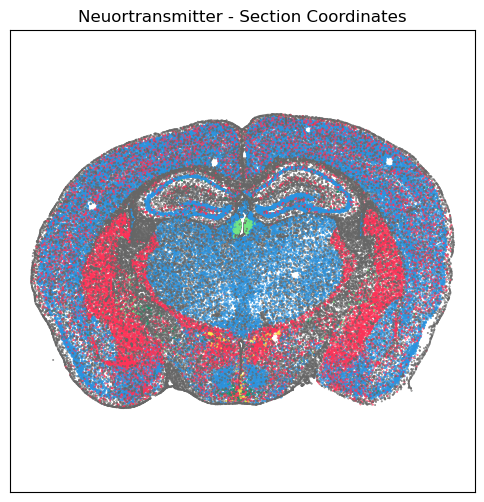

In [11]:
fig, ax = plot_section(xx=section['x_section'],
                       yy=section['y_section'], 
                       cc=section['neurotransmitter_color'])
res = ax.set_title("Neuortransmitter - Section Coordinates")

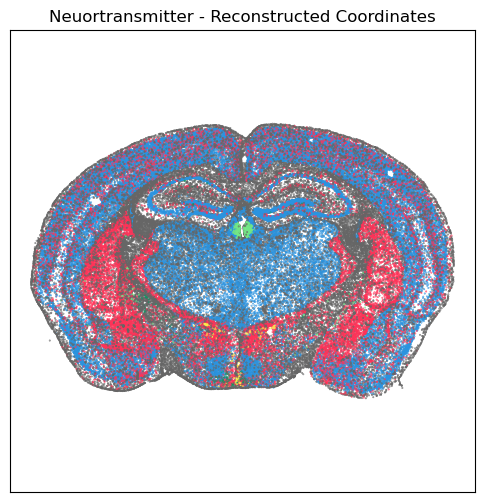

In [12]:
fig, ax = plot_section(xx=section['x_reconstructed'],
                       yy=section['y_reconstructed'], 
                       cc=section['neurotransmitter_color'])
res = ax.set_title("Neuortransmitter - Reconstructed Coordinates")

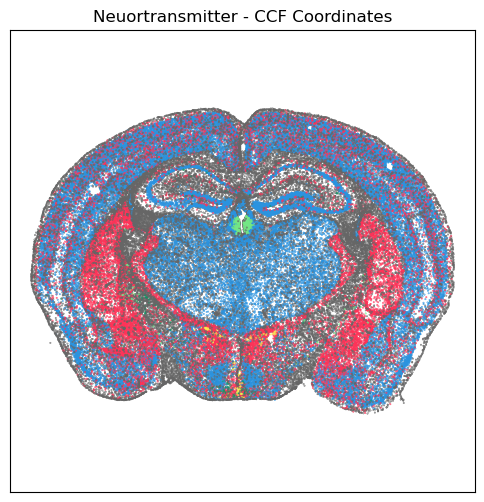

In [13]:
fig, ax = plot_section(xx=section['z_ccf'],
                       yy=section['y_ccf'], 
                       cc=section['neurotransmitter_color'])
res = ax.set_title("Neuortransmitter - CCF Coordinates")

### Associate mapped parcellation and parcellation terms to the MERFISH data

Read in the pivoted parcellation annotation information we create in the Allen CCFv3 tutorial and join with the cell metadata dataframe.

In [14]:
parcellation_annotation = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020',
                                                           file_name='parcellation_to_parcellation_term_membership_acronym')
parcellation_annotation.set_index('parcellation_index', inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]
parcellation_annotation.head(5)

,parcellation_organ,parcellation_category,parcellation_division,parcellation_structure,parcellation_substructure
parcellation_index,,,,,
0,unassigned,unassigned,unassigned,unassigned,unassigned
1,brain,grey,HY,TMv,TMv
2,brain,grey,Isocortex,SSp-m,SSp-m6b
5,brain,fiber tracts,lfbs,cst,int
6,brain,grey,P,PSV,PSV


In [15]:
parcellation_color = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020',
                                                      file_name='parcellation_to_parcellation_term_membership_color')
parcellation_color.set_index('parcellation_index', inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]
parcellation_color.head(5)

,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color
parcellation_index,,,,,
0,#000000,#000000,#000000,#000000,#000000
1,#FFFFFF,#BFDAE3,#E64438,#FF4C3E,#FF4C3E
2,#FFFFFF,#BFDAE3,#70FF71,#188064,#188064
5,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC
6,#FFFFFF,#BFDAE3,#FF9B88,#FFAE6F,#FFAE6F


In [16]:
cell_joined = cell_joined.join(parcellation_annotation, on='parcellation_index')
cell_joined = cell_joined.join(parcellation_color, on='parcellation_index')
cell_joined.head(5)

,brain_section_label,cluster_alias,average_correlation_score,feature_matrix_label,donor_label,donor_genotype,donor_sex,x_section,y_section,z_section,...,parcellation_organ,parcellation_category,parcellation_division,parcellation_structure,parcellation_substructure,parcellation_organ_color,parcellation_category_color,parcellation_division_color,parcellation_structure_color,parcellation_substructure_color
cell_label,,,,,,,,,,,,,,,,,,,,,
1019171907102340387-1,C57BL6J-638850.37,1408,0.596276,C57BL6J-638850,C57BL6J-638850,wt/wt,M,7.226245,4.148963,6.6,...,brain,grey,HPF,DG,DG-po,#FFFFFF,#BFDAE3,#7ED04B,#7ED04B,#7ED04B
1104095349101460194-1,C57BL6J-638850.26,4218,0.641180,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.064889,7.309543,4.2,...,brain,grey,P,TRN,TRN,#FFFFFF,#BFDAE3,#FF9B88,#FFBA86,#FFBA86
1017092617101450577,C57BL6J-638850.25,4218,0.763531,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.792921,8.189973,4.0,...,brain,grey,P,P-unassigned,P-unassigned,#FFFFFF,#BFDAE3,#FF9B88,#FF9B88,#FF9B88
1018093344101130233,C57BL6J-638850.13,4218,0.558073,C57BL6J-638850,C57BL6J-638850,wt/wt,M,3.195950,5.868655,2.4,...,brain,fiber tracts,cbf,arb,arb,#FFFFFF,#CCCCCC,#CCCCCC,#CCCCCC,#CCCCCC
1019171912201610094,C57BL6J-638850.27,4218,0.591009,C57BL6J-638850,C57BL6J-638850,wt/wt,M,5.635732,7.995842,4.4,...,brain,grey,P,P-unassigned,P-unassigned,#FFFFFF,#BFDAE3,#FF9B88,#FF9B88,#FF9B88


The joined DataFrame ``cell_joined`` created above is available from the cache as the file ``cell_metadata_with_parcellation_annotation``.

### Visualize cell parcellation assignment at different anatomical levels

For example section "C57BL6J-638850.40", we plot cells reconstructed coordinates colorized by parcellation assignment at the division and structure anatomical levels

In [17]:
pred = (cell_joined['brain_section_label'] == brain_section)
section = cell_joined[pred]
print(len(section))

104572


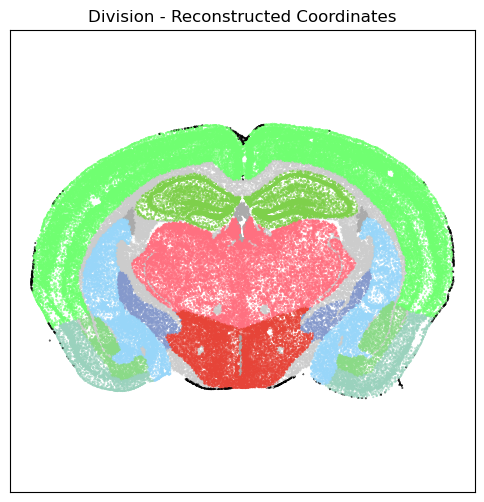

In [18]:
fig, ax = plot_section(xx=section['x_reconstructed'],
                       yy=section['y_reconstructed'], 
                       cc=section['parcellation_division_color'])
res = ax.set_title("Division - Reconstructed Coordinates")

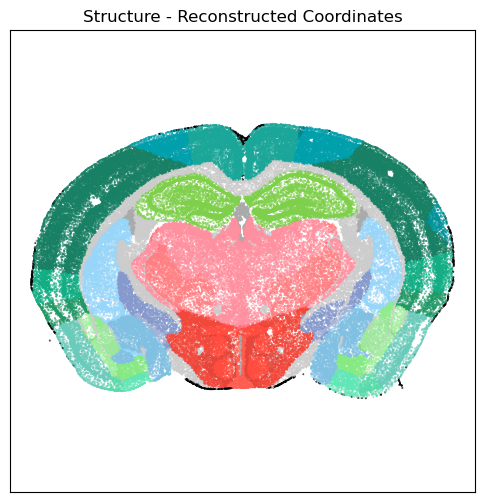

In [19]:
fig, ax = plot_section(xx=section['x_reconstructed'],
                       yy=section['y_reconstructed'], 
                       cc=section['parcellation_structure_color'])
res = ax.set_title("Structure - Reconstructed Coordinates")

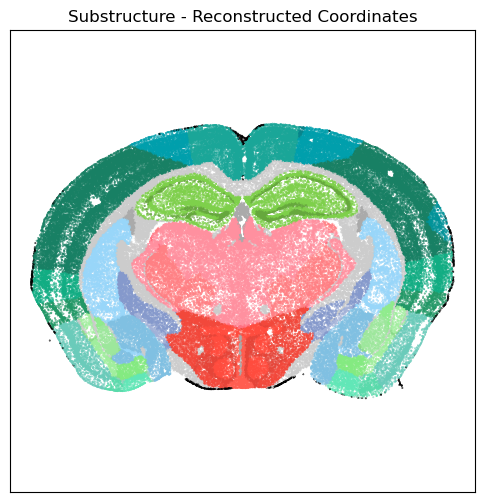

In [20]:
fig, ax = plot_section(xx=section['x_reconstructed'],
                       yy=section['y_reconstructed'], 
                       cc=section['parcellation_substructure_color'])
res = ax.set_title("Substructure - Reconstructed Coordinates")

### Aggregate cells by parcellation assignment at different anatomical levels

Define a helper function to count the number of cells for each term and apply it to the division and structure anatomical levels

In [21]:
def parcellation_cell_count (df,level) :
    cell_count = df.groupby(level)[['cluster_alias']].count()
    cell_count.columns = ['number_of_cells']
    cell_count.sort_values('number_of_cells', ascending=False, inplace=True)
    return cell_count

In [22]:
cell_count = parcellation_cell_count(cell_joined, 'parcellation_division')
cell_count.head(10)

,number_of_cells
parcellation_division,
Isocortex,935742
STR,401346
CB,383127
HPF,304642
MB,281852
OLF,274354
MY,147562
P,136569
TH,133805


In [23]:
cell_count = parcellation_cell_count(section, 'parcellation_structure')
cell_count.head(10)

,number_of_cells
parcellation_structure,
SSp-bfd,8865
SSs,7210
CP,4715
DG,4491
VISa,4462
CA1,3705
PIR,3119
cst,3000
cc,2858


We can filtered cells to specific subclasses and types and count within the filtered set

In [24]:
pred = (cell_joined['subclass'] == '145 MH Tac2 Glut')
filtered = cell_joined[pred]
print("number of cells:", len(filtered))
cell_count = parcellation_cell_count(filtered, 'parcellation_structure')
cell_count.head(10)

number of cells: 4696


,number_of_cells
parcellation_structure,
MH,4404
V3-unassigned,132
mfsbshy,73
brain-unassigned,46
chpl,21
LH,12
DG,3
TH-unassigned,2
LP,1


In [25]:
pred = (cell_joined['subclass'] == '146 LH Pou4f1 Sox1 Glut')
filtered = cell_joined[pred]
print("number of cells:", len(filtered))
cell_count = parcellation_cell_count(filtered, 'parcellation_structure')
cell_count.head(10)

number of cells: 1067


,number_of_cells
parcellation_structure,
LH,851
mfsbshy,109
MH,59
PAG,10
TH-unassigned,10
brain-unassigned,7
PF,6
DG,5
MD,4


In [26]:
pred = (cell_joined['subclass'] == '147 AD Serpinb7 Glut')
filtered = cell_joined[pred]
print("number of cells:", len(filtered))
cell_count = parcellation_cell_count(filtered, 'parcellation_structure')
cell_count.head(10)

number of cells: 1190


,number_of_cells
parcellation_structure,
AD,1036
mfsbshy,84
brain-unassigned,35
DG,22
LD,4
AM,3
TH-unassigned,3
mfbc,3


In [27]:
pred = (cell_joined['subclass'] == '007 L2/3 IT CTX Glut')
filtered = cell_joined[pred]
print("number of cells:", len(filtered))
cell_count = parcellation_cell_count(filtered, 'parcellation_substructure')
cell_count.head(10)

number of cells: 121784


,number_of_cells
parcellation_substructure,
MOs2/3,12762
MOp2/3,10586
VISp2/3,9250
SSs2/3,7149
SSp-m2/3,5203
SSp-bfd2/3,5032
TEa2/3,4396
SSp-ul2/3,3337
RSPagl2/3,3142


### Resampled CCF template and parcellations

The anatomical template, parcellation and boundary volume in resample CCF coordinates are also available for download for visualization and analysis

In [28]:
abc_cache.list_data_files('MERFISH-C57BL6J-638850-CCF')

['resampled_annotation',
 'resampled_annotation_boundary',
 'resampled_average_template']

In [29]:
print("reading resampled_average_template")
file = abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850-CCF',
                               file_name='resampled_average_template')
average_template_image = sitk.ReadImage(file)
average_template_array = sitk.GetArrayViewFromImage(average_template_image)

print("reading resampled_annotation")
file = abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850-CCF',
                               file_name='resampled_annotation')
annotation_image = sitk.ReadImage(file)
annotation_array = sitk.GetArrayViewFromImage(annotation_image)

print("reading resampled_annotation_boundary")
file = abc_cache.get_data_path(directory='MERFISH-C57BL6J-638850-CCF',
                               file_name='resampled_annotation_boundary')
annotation_boundary_image = sitk.ReadImage(file)
annotation_boundary_array = sitk.GetArrayViewFromImage(annotation_boundary_image)

reading resampled_average_template


resampled_average_template.nii.gz: 100%|██████████████████████████████████████████████████████████████████████████| 117M/117M [00:03<00:00, 38.0MMB/s]


reading resampled_annotation


resampled_annotation.nii.gz: 100%|██████████████████████████████████████████████████████████████████████████████| 2.12M/2.12M [00:00<00:00, 22.6MMB/s]


reading resampled_annotation_boundary


resampled_annotation_boundary.nii.gz: 100%|█████████████████████████████████████████████████████████████████████| 1.55M/1.55M [00:00<00:00, 10.8MMB/s]


In [30]:
# Function to print out image information
def image_info(img):
    print('size: ' + str(img.GetSize()) + ' voxels')
    print('spacing: ' + str(img.GetSpacing()) + ' mm' )
    print('direction: ' + str(img.GetDirection()) )
    print('origin: ' + str(img.GetOrigin()))

In [31]:
image_info(average_template_image)

size: (1100, 1100, 76) voxels
spacing: (0.009999999776482582, 0.009999999776482582, 0.20000000298023224) mm
direction: (-1.0, 0.0, 0.0, 0.0, -0.0, -1.0, 0.0, -1.0, 0.0)
origin: (5.476531505584717, 8.600000381469727, 6.435669422149658)


To enable the overlay of image section with cell coordinates we need to compute the extent the image in mm coordinates

In [32]:
size = average_template_image.GetSize()
spacing = average_template_image.GetSpacing()
extent = (-0.5 * spacing[0], (size[0]-0.5) * spacing[0], (size[1]-0.5) * spacing[1], -0.5 * spacing[1])

### Visualize cells with parcellation boundary overlay

For example section "C57BL6J-638850.40", we first compute the corresponding z section in the resampled image volume and visualize the resampled average template, annotation and parcellation for that section 

In [33]:
zindex = int(section.iloc[0]['z_reconstructed'] / 0.2)
zindex

36

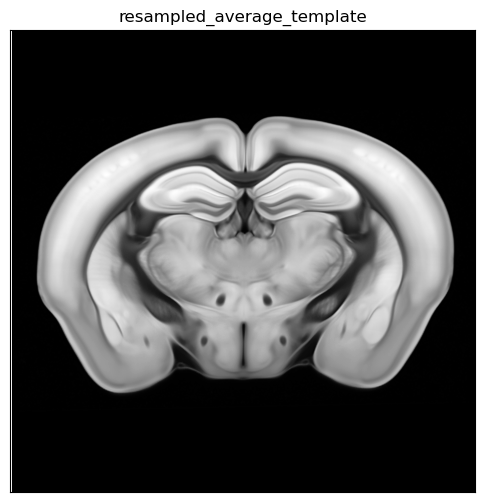

In [34]:
template_slice = average_template_array[zindex, :, :]
fig, ax = plot_section(overlay=template_slice, extent=extent)
res = ax.set_title('resampled_average_template')

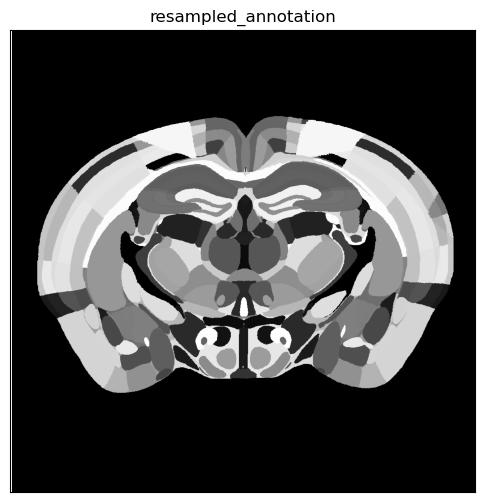

In [35]:
annotation_slice = annotation_array[zindex, :, :]
fig, ax = plot_section(overlay=annotation_slice, extent=extent)
res = ax.set_title('resampled_annotation')

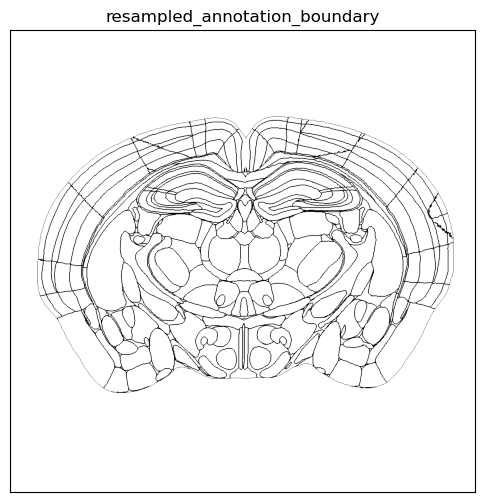

In [36]:
boundary_slice = annotation_boundary_array[zindex, :, :]
fig, ax = plot_section(overlay=boundary_slice, bcmap=plt.cm.Greys, extent=extent)
res = ax.set_title('resampled_annotation_boundary')

Using the help function, we can overlay the parcellation boundary overlay on top of the cells colorized by subclass

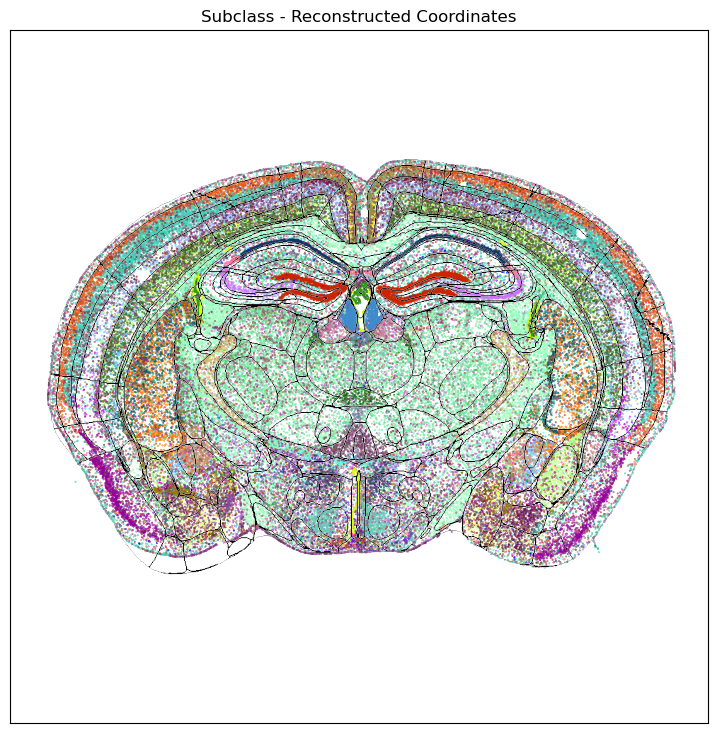

In [37]:
fig, ax = plot_section(section['x_reconstructed'],
                       section['y_reconstructed'], 
                       cc=section['subclass_color'],
                       overlay=boundary_slice,
                       extent=extent, 
                       cmap=plt.cm.Greys,
                       alpha = 1.0*(boundary_slice>0),
                       fig_width = 9,
                       fig_height = 9 )
res = ax.set_title("Subclass - Reconstructed Coordinates")